# Space Environment Pathways
This Jupyter Notebook will allow users to play around with the scenarios, in order to get to know the laucnh data.

If you would like to use the scen_properties of a pickle file, then this must be located under the first pyssem folder. In the same folder as model.py

### Things of note:
- Su species has a much larger mass across the samples in general, so the chosen values are very high compared to before, on the order of 10^3 kg...
- SnS has a few samples with very tiny radii: 4 out of 14 have radius < 0.05m: [0.0444285 0.027457  0.027457  0.0444285]. This seems to be smaller than a typical cubesat.
- there are some outliers in N with very large radii, so I cut (still keeping 99.69% of them by cutting to those under 12kg)


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.time import Time

In [3]:
path = '/Users/indigobrownhall/Code/pyssem/pyssem/utils/launch/data/ref_scen_SEP2.csv' # your path to the scenario csv file
T = pd.read_csv(path)
T['apogee'] = T['sma'] * (1 + T['ecc'])
T['perigee'] = T['sma'] * (1 - T['ecc'])
T['alt'] = (T['apogee'] + T['perigee']) / 2 - 6378.1

T = T[T['alt'] <= 2000]
T = T[T['alt'] >= 200]
# T = T[T['year_start'] <= 2025]

/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_74881/955533804.py:2: DtypeWarning: Columns (4,5,63) have mixed types. Specify dtype option on import or set low_memory=False.
  T = pd.read_csv(path)


### Isabella's New SEP Plotting
Now, we can run SEPTSoSpecies.py

In [ ]:
# This function has been taken for pyssem and allows you to pass a list of species queries and test it. 

def assign_species_to_population(T, species_mapping):
    """
    Applies a list of pandas query strings to assign species classes to the population.
    
    :param T: pandas.DataFrame representing the population
    :param species_mapping: list of assignment strings (e.g., T.loc[...] = ...)
    :return: updated DataFrame with 'species_class' assigned
    """
    # Initialize the column
    T['species_class'] = "Unknown"

    # Apply each mapping rule via exec
    for rule in species_mapping:
        try:
            exec(rule)
        except Exception as e:
            print(f"Error applying rule: {rule}\n\t{e}")

    # Print summary of resulting species_class assignments
    print("\nSpecies class distribution:")
    print(T['species_class'].value_counts())

    # Remove all objects that are still unknown
    try:
        
        T = T[T['species_class'] != "Unknown"]
        print(f"\n{T['species_class'].value_counts()['Unknown']} objects/rows are being removed.")
    except KeyError:
        print("No unknown species classes found.")

    return T

species_configuration = [
      "T.loc[(T['obj_type'] == 2) & (T['phase'] == 2) & (T['maneuverable'] == 1), 'species_class'] = 'Su'",
      "T.loc[(T['obj_type'] == 2) & (T['mass'] <= 20) & (T['phase'] == 2), 'species_class'] = 'Sns'",
      "T.loc[(T['obj_type'] == 2) & (T['phase'] == 2) & (T['maneuverable'] == 1) & T['const_name'].notna(), 'species_class'] = 'S'",
      "T.loc[(T['obj_type'] >= 3) & (T['diam_char'] >= 0.05) & (T['diam_char']/2 < 10), 'species_class'] = 'N'",
      "T.loc[(T['obj_type'] == 1), 'species_class'] = 'B'"
]
assigned_df = assign_species_to_population(T, species_configuration)

In [5]:
species_configuration = [
      "T.loc[(T['obj_type'] == 2) & (T['phase'] == 2) & (T['maneuverable'] == 1), 'species_class'] = 'Su'",
      "T.loc[(T['obj_type'] == 2) & (T['mass'] <= 20) & (T['phase'] == 2), 'species_class'] = 'Sns'",
      "T.loc[(T['obj_type'] == 2) & (T['phase'] == 2) & (T['maneuverable'] == 1) & T['const_name'].notna(), 'species_class'] = 'S'",
      "T.loc[(T['obj_type'] >= 3) & (T['diam_char'] >= 0.05) & (T['diam_char']/2 < 10), 'species_class'] = 'N'",
      "T.loc[(T['obj_type'] == 1), 'species_class'] = 'B'"
]
assigned_df = assign_species_to_population(T, species_configuration)


Species class distribution:
species_class
Unknown    363936
S          288279
Sns         26376
Su          21168
N           19709
B            6034
Name: count, dtype: int64
No unknown species classes found.


In [6]:
big_mass = 10000
heavy = assigned_df[assigned_df['mass'] > big_mass]

heavy = heavy[heavy['species_class']=="B"] # all others are NA
max_mass = heavy["mass"].max()

print(f"Number of objects > {big_mass} kg: {len(heavy)}")
print(heavy['species_class'].value_counts())
print(f"maximum mass: {max_mass}")

heavy


Number of objects > 10000 kg: 0
Series([], Name: count, dtype: int64)
maximum mass: nan


,obj_id,phase_desc,phase,par_id,operating_agency,const_name,const_shell_id,mass,area,diam_lcola,...,eci_y,eci_z,eci_vx,eci_vy,eci_vz,obj_id_str,species_class,apogee,perigee,alt


These will be outliers we later remove in the statistical analysis for clustering!

In [7]:
remove_outliers = True

In [8]:
assigned_df['species_class'].dropna().unique()

array(['B', 'N', 'S', 'Su', 'Sns'], dtype=object)

/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_74881/3009118959.py:16: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


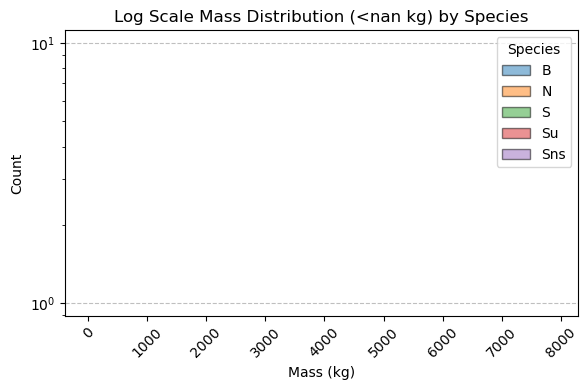

Length of data for B: 0


ZeroDivisionError: float division by zero

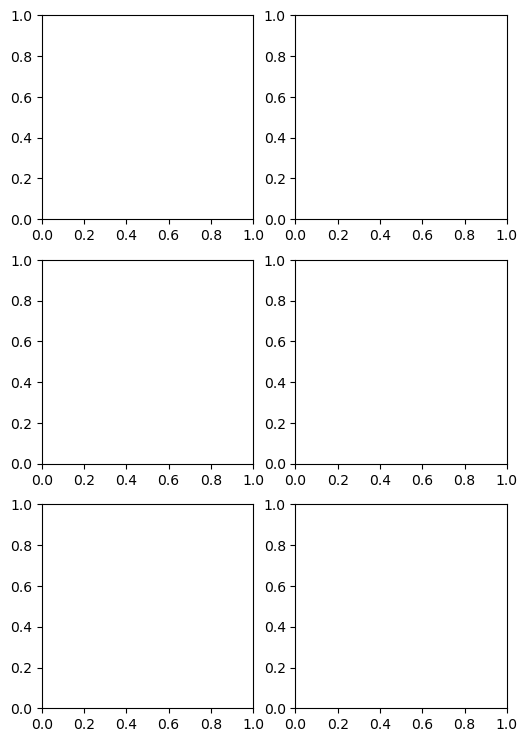

In [9]:
all_species = assigned_df['species_class'].dropna().unique()
bins = np.arange(0, 8000, 100)
plt.figure(figsize=(6,4))

for species in all_species:
    mask = (assigned_df['mass'] < max_mass) & (assigned_df['species_class'] == species)
    subset = assigned_df.loc[mask, 'mass'].dropna()
    # overlay each species, with a bit of transparency
    plt.hist(subset, bins=bins, alpha=0.5, label=species, edgecolor='black')

plt.title(f"Log Scale Mass Distribution (<{max_mass} kg) by Species")
plt.xlabel("Mass (kg)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Species")
plt.yscale('log')

plt.grid(axis='y', linestyle='--', alpha=0.8)
plt.tight_layout()
plt.show()


n = len(all_species)
ncols = 2
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(6, 3*nrows), sharex=False, sharey=False)
axes = axes.flatten()

for ax, sp in zip(axes, all_species):
    data = assigned_df.loc[
        (assigned_df['species_class']==sp) & 
        (assigned_df['mass'] < max_mass),
        'mass'
    ].dropna()
    
    max_data_mass = data.max() if not data.empty else 0
    print(f"Length of data for {sp}: {len(data)}")

    bins_sp = np.arange(0, max_data_mass + 30, max_data_mass / 20)
    ax.hist(data, bins=bins_sp, edgecolor='black')
    
    if sp != "B":
        ax.set_title(f"Species = {sp}")
    else:
        ax.set_title(f"Species = {sp} (One large outlier removed)")

    if max_data_mass > 1:
        ax.set_xlim(0, max_data_mass+(max_data_mass*0.1))  # Add 10% margin to the max mass
    else:
        ax.set_xlim(0, 1)
    
    ax.set_xlabel("Mass (kg)")
    ax.set_ylabel("Count")
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    
    # if sp == "Sns":
    #     print(f"All data for {sp}:\n{data.describe()}")
    #     print(list(data))

fig.suptitle(f"Mass Distributions (all <{max_mass} kg) by Species", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
big_mass_points.value_counts()

mass
False    21105
True        63
Name: count, dtype: int64

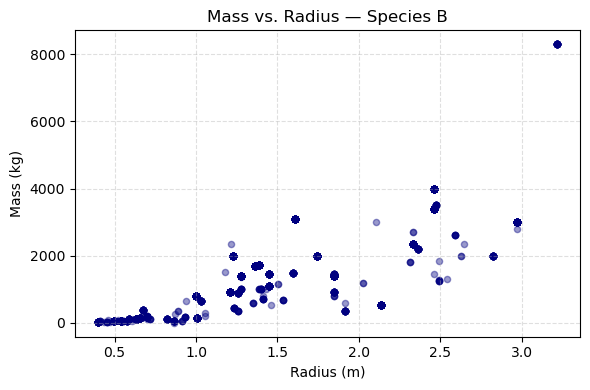

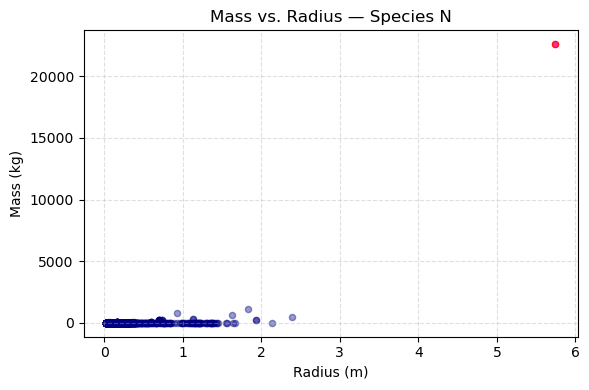

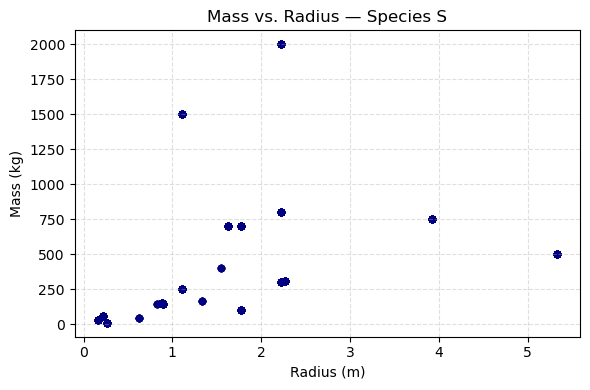

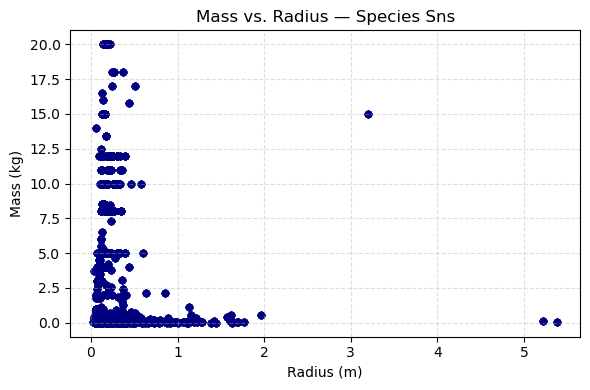

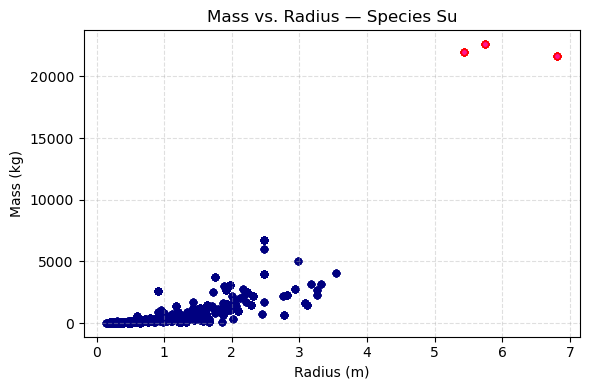

In [10]:
mass_radius_df = assigned_df[['species_class','mass','diam_char']].dropna()
mass_radius_df['radius'] = mass_radius_df['diam_char'] / 2

for sp, group in mass_radius_df.groupby('species_class'):
    plt.figure(figsize=(6,4))

    
    if remove_outliers:
        big_mass_points = group['mass'] > big_mass
    
    # Plot normal points
    plt.scatter(
        group.loc[~big_mass_points, 'radius'],
        group.loc[~big_mass_points, 'mass'],
        s=20, alpha=0.4, color = 'navy', label='not outlier'
    )

    plt.scatter(
        group.loc[big_mass_points, 'radius'],
        group.loc[big_mass_points, 'mass'],
        s=20, alpha=0.9, color='deeppink', edgecolor='red', label='outlier'
    )
    
    plt.title(f"Mass vs. Radius — Species {sp}")
    plt.xlabel("Radius (m)")
    plt.ylabel("Mass (kg)")
    plt.grid(True, linestyle='--', alpha=0.4)
    
    plt.tight_layout()
    plt.show()

In [11]:
# how many SnS have small radius?
print(f"Number of SnS with radius < 0.05 m: {len(mass_radius_df[(mass_radius_df['species_class']=='Sns') & (mass_radius_df['radius'] < 0.05)])}")

# print out the radii values
print("Radii of SnS with radius < 0.05 m:")
print(mass_radius_df[(mass_radius_df['species_class']=='Sns') & (mass_radius_df['radius'] < 0.05)]['radius'].values)

Number of SnS with radius < 0.05 m: 924
Radii of SnS with radius < 0.05 m:
[0.043416  0.043416  0.0304945 0.043416  0.043416  0.0381195 0.0304945
 0.043416  0.043416  0.043416  0.043416  0.043416  0.043416  0.043416
 0.043416  0.043416  0.043416  0.043416  0.043416  0.043416  0.043416
 0.043416  0.043416  0.043416  0.043416  0.043416  0.043416  0.043416
 0.043416  0.043416  0.043416  0.0354485 0.0358095 0.0354485 0.028079
 0.0362535 0.0444285 0.0444285 0.0444285 0.0444285 0.0444285 0.0444285
 0.0444285 0.0444285 0.043416  0.043416  0.0304945 0.043416  0.043416
 0.0381195 0.0304945 0.043416  0.043416  0.043416  0.043416  0.043416
 0.043416  0.043416  0.043416  0.043416  0.043416  0.043416  0.043416
 0.043416  0.043416  0.043416  0.043416  0.043416  0.043416  0.043416
 0.043416  0.043416  0.043416  0.043416  0.043416  0.0354485 0.0358095
 0.0354485 0.028079  0.0362535 0.0444285 0.0444285 0.0444285 0.0444285
 0.0444285 0.0444285 0.0444285 0.0444285 0.043416  0.043416  0.0304945
 0.043416 

### New Statistical Analysis

In [12]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
# from sklearn_extra.cluster import KMedoids

NOTE: K medoids take much longer to compute. Select the following boolean as needed!

In [13]:
# Set to True to include KMedoids clustering
include_medoids = False  

We removed the following B outliers:
Empty DataFrame
Columns: [radius, mass]
Index: []


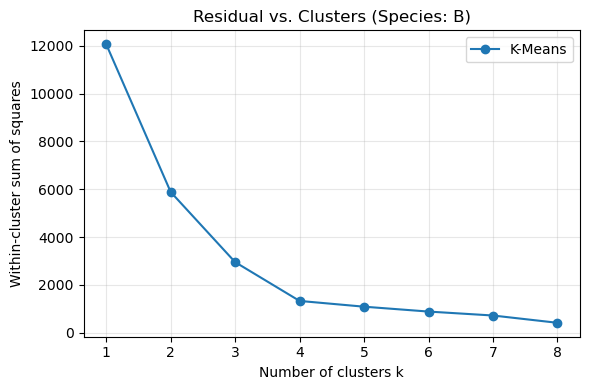

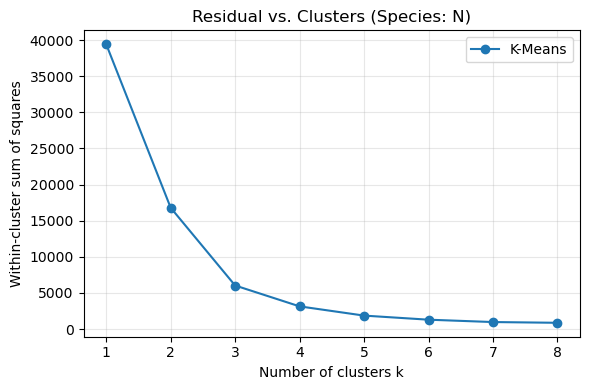

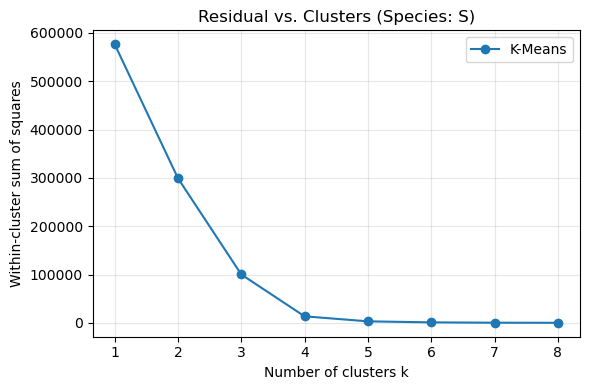

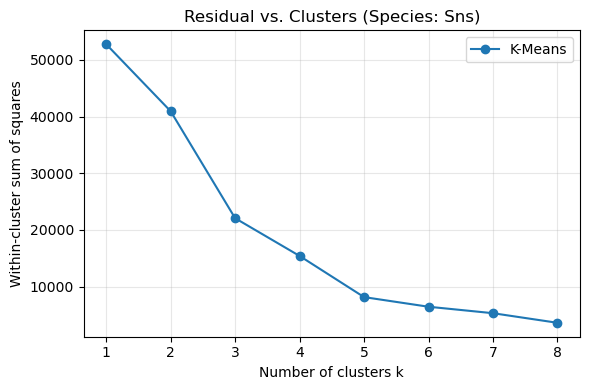

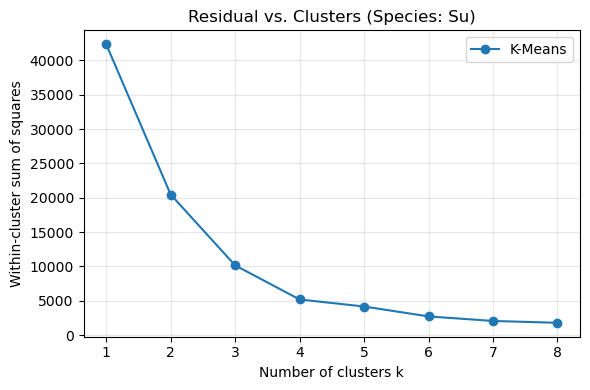

In [14]:
species_groups = mass_radius_df.groupby('species_class')
Xs_by_species = {}
cleaned_groups = {}

for sp, group in species_groups:
    
    # clean up outlier
    if sp == "B":
        B_outliers = group[group['mass'] >= big_mass]
        print("We removed the following B outliers:")
        print(B_outliers[['radius', 'mass']])
        
        group = group[group['mass'] < big_mass]
    cleaned_groups[sp] = group
        
    df = group[['radius', 'mass']].dropna()
    X = df.values
    Xs_by_species[sp] = StandardScaler().fit_transform(X)
    Xs = Xs_by_species[sp] # for use in the loop below
    
    inertia_kmeans  = []
    resid_kmedians  = []
    
    # Computer WCSS (intertia) for k = 1, ..., 8
    ks = range(1,9)
    for k in ks:
        km = KMeans(n_clusters=k, random_state=0).fit(Xs)
        inertia_kmeans.append(km.inertia_)  
        
        # k-medians
        if include_medoids and sp!="N":
            kmn = KMedoids(n_clusters=k, metric='manhattan', init='k-medoids++', random_state=0).fit(Xs)
            # sum of L1 distances to each cluster’s medoid
            # resid = np.sum(kmn.inertia_)  # sklearn_extra uses ‘inertia_’ as sum of distances
            # resid_kmedians.append(resid)
            resid_kmedians.append(kmn.inertia_)
    
    # plot elbow
    plt.figure(figsize=(6, 4))
    plt.plot(ks, inertia_kmeans, '-o', label='K-Means')
    if include_medoids and sp!="N":
        plt.plot(ks, resid_kmedians, '-s', label='K-Medoids')
    plt.xticks(ks)
    plt.xlabel('Number of clusters k')
    plt.ylabel('Within-cluster sum of squares')
    plt.title(f'Residual vs. Clusters (Species: {sp})')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


From this, I think the following # clusters make most sense:
- B: 2
- N: 2
- S: 3
- SnS: 2
- Su: 2

In [15]:
species_names = list(Xs_by_species.keys())
species_names

['B', 'N', 'S', 'Sns', 'Su']

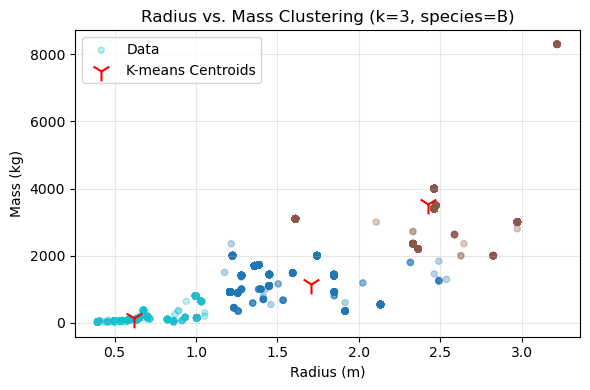

length of data for species B: 6034
K-means centroid coordinates (radius (m), mass (kg)) for species B (k=3):
  Cluster 1: (1.70643, 1144.79176)
  Cluster 2: (2.42637, 3534.86210)
  Cluster 3: (0.61977, 148.18288)


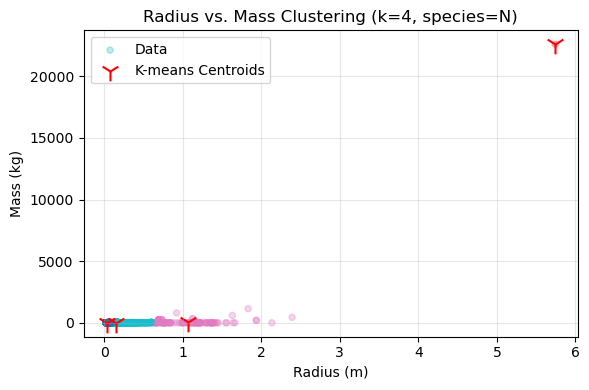

length of data for species N: 19709
K-means centroid coordinates (radius (m), mass (kg)) for species N (k=4):
  Cluster 1: (0.04106, 0.08696)
  Cluster 2: (5.74419, 22600.00000)
  Cluster 3: (1.07304, 60.77548)
  Cluster 4: (0.15504, 0.76017)


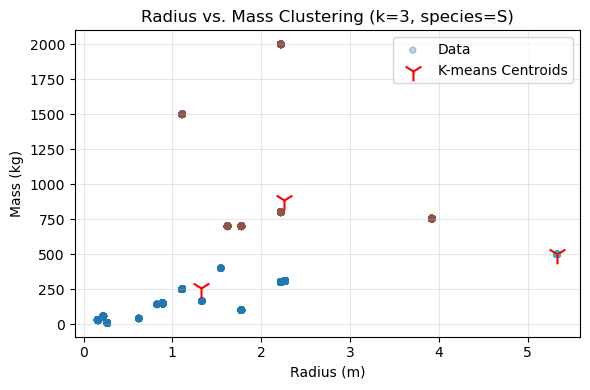

length of data for species S: 288279
K-means centroid coordinates (radius (m), mass (kg)) for species S (k=3):
  Cluster 1: (1.32534, 256.55266)
  Cluster 2: (2.25270, 886.91322)
  Cluster 3: (5.33141, 500.00000)


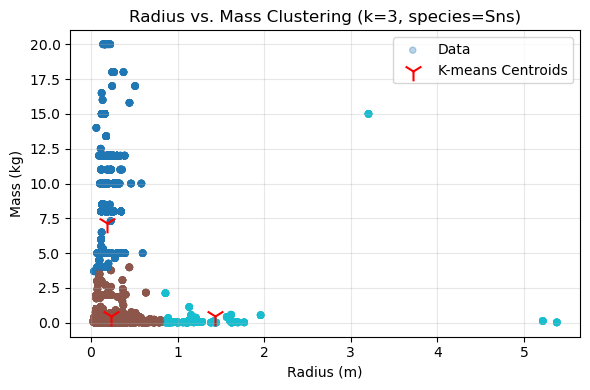

length of data for species Sns: 26376
K-means centroid coordinates (radius (m), mass (kg)) for species Sns (k=3):
  Cluster 1: (0.17941, 7.16764)
  Cluster 2: (0.22762, 0.45789)
  Cluster 3: (1.43096, 0.50356)


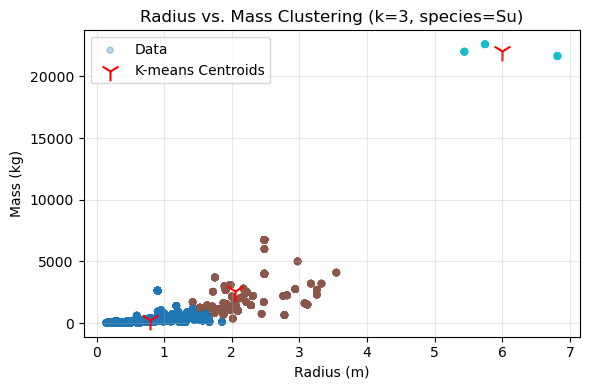

length of data for species Su: 21168
K-means centroid coordinates (radius (m), mass (kg)) for species Su (k=3):
  Cluster 1: (0.79147, 283.77189)
  Cluster 2: (2.04126, 2590.23643)
  Cluster 3: (5.99980, 22083.33333)


In [16]:
# Cluster fit on K-means
species_names = list(Xs_by_species.keys())
k_list = [2, 2, 3, 2, 2]
k_list = [3, 4, 3, 3, 3]


for i, sp in enumerate(species_names):
    X = Xs_by_species[sp]
    k = k_list[i]
    group = cleaned_groups[sp]
    
    km = KMeans(n_clusters=k, random_state=0).fit(X)
    labels = km.labels_
    
    # unscale centers before plotting!
    scaler = StandardScaler().fit(group[['radius', 'mass']].dropna().values)
    centers_scaled = km.cluster_centers_
    centers_unscaled = scaler.inverse_transform(centers_scaled)
    
    if include_medoids and sp != "N":
        kmn = KMedoids(n_clusters=k, metric='manhattan', init='k-medoids++', random_state=0).fit(X)
        labels_medoids = kmn.labels_
        medoids = kmn.cluster_centers_
        medoids_unscaled = scaler.inverse_transform(medoids)

    
    df = group[['radius', 'mass']].dropna()
    
    plt.figure(figsize=(6, 4))
    plt.scatter(df['radius'], df['mass'], c=labels, cmap='tab10', s=20, alpha=0.3, label='Data')
    plt.scatter(centers_unscaled[:, 0], centers_unscaled[:, 1],
                marker='1', c='red', s=200, label='K-means Centroids')
    if include_medoids and sp != "N":
        plt.scatter(medoids_unscaled[:, 0], medoids_unscaled[:, 1],
                marker='2', c='blue', s=200, label='K-Medoids Medoids' if include_medoids else None)
    plt.xlabel('Radius (m)')
    plt.ylabel('Mass (kg)')
    plt.title(f'Radius vs. Mass Clustering (k={k}, species={sp})')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"length of data for species {sp}: {len(df)}")
    
    print(f"K-means centroid coordinates (radius (m), mass (kg)) for species {sp} (k={k}):")
    for j, center in enumerate(centers_unscaled):
        print(f"  Cluster {j+1}: ({center[0]:.5f}, {center[1]:.5f})")
     
    if include_medoids and sp != "N":
        print(f"K-Medoids centroid coordinates (radius (m), mass (kg)) for species {sp} (k={k}):")
        for j, medoid in enumerate(medoids_unscaled):
            print(f"  Medoid {j+1}: ({medoid[0]:.5f}, {medoid[1]:.5f})")
    

length of data for species N before removing outlier: 19709
length of data for species N after removing outlier: 19658
percentage remaining: 99.74123496879598%


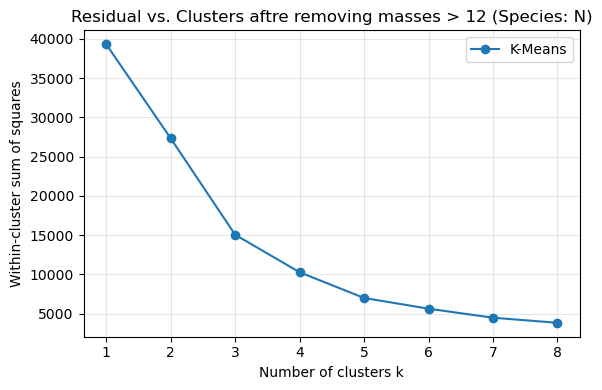

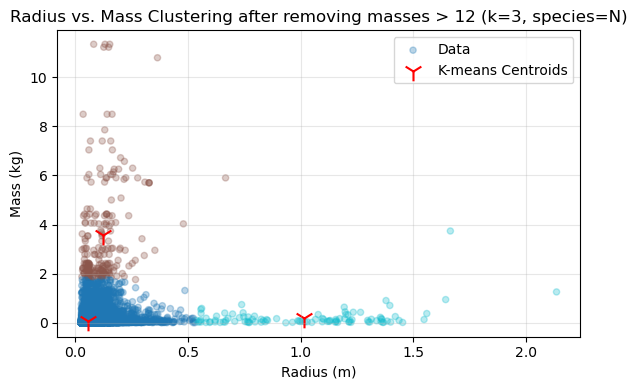

K-means centroid coordinates (area (m), radius (m), mass (kg), bstar) for species N (k=2):
  Cluster 1: (0.00993, 0.05622, 0.08423, 2.5932459532652153e-07)
  Cluster 2: (0.04688, 0.12216, 3.56023, 2.8971227367366304e-08)
  Cluster 3: (3.23145, 1.01420, 0.21096, 3.369878848061469e-05)


In [17]:
# we will try clustering with 2 clusters, for N after removing outlier.
N_noutlier = mass_radius_df[mass_radius_df['species_class']=='N'].copy()
# before removing outlier, print length of data
length_before = len(N_noutlier)
print(f"length of data for species N before removing outlier: {length_before}")
N_noutlier = N_noutlier[N_noutlier['mass'] < 12]  # remove outlier
# length of data after removing outlier, and percentage of points remaining
length_after = len(N_noutlier)
print(f"length of data for species N after removing outlier: {length_after}")
pct_remaining = (length_after / length_before) * 100
print(f"percentage remaining: {pct_remaining:}%")

X_N = N_noutlier[['radius', 'mass']].dropna().values
X_N_scaled = StandardScaler().fit_transform(X_N)

inertia_kmeans  = []
resid_kmedians  = []
    
# elbow
ks = range(1,9)
for k in ks:
    km = KMeans(n_clusters=k, random_state=0).fit(X_N_scaled)
    inertia_kmeans.append(km.inertia_)  
    
    # plot elbow
plt.figure(figsize=(6, 4))
plt.plot(ks, inertia_kmeans, '-o', label='K-Means')
plt.xticks(ks)
plt.xlabel('Number of clusters k')
plt.ylabel('Within-cluster sum of squares')
plt.title(f'Residual vs. Clusters aftre removing masses > 12 (Species: N)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# find clusters
km_N = KMeans(n_clusters=3, random_state=0).fit(X_N_scaled)

labels_N = km_N.labels_
centers_N_scaled = km_N.cluster_centers_


# unscale centers for plotting
scaler_N = StandardScaler().fit(X_N)
centers_N_unscaled = scaler_N.inverse_transform(centers_N_scaled)
# Plot the results
plt.figure(figsize=(6, 4))
plt.scatter(X_N[:, 0], X_N[:, 1], c=labels_N, cmap='tab10', s=20, alpha=0.3, label='Data')      
plt.scatter(centers_N_unscaled[:, 0], centers_N_unscaled[:, 1],
                marker='1', c='red', s=200, label='K-means Centroids')

plt.xlabel('Radius (m)')
plt.ylabel('Mass (kg)')
plt.title(f'Radius vs. Mass Clustering after removing masses > 12 (k=3, species=N)')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# print the coordinates of the centers
print(f"K-means centroid coordinates (area (m), radius (m), mass (kg), bstar) for species N (k=2):")
for j, center in enumerate(centers_N_unscaled):
    # print(f"  Cluster {j+1}: ({center[0]:.5f}, {center[1]:.5f})")
    area = np.pi * (center[0]**2)
    bstar = 2.2 * (area * 1e-6/ center[1])
    # print(f" Area of cluster {j+1}: {area:.5f} m^2, Bstar: {bstar}")
    print(f"  Cluster {j+1}: ({area:.5f}, {center[0]:.5f}, {center[1]:.5f}, {bstar                                                                             })")


## Time and Phase related study

In [18]:
# Filter to Sns
T_new = assigned_df.copy()
sns = T_new[T_new['species_class']=='Sns']
s = T_new[T_new['species_class']=='S']
n = T_new[T_new['species_class']=='N']
b = T_new[T_new['species_class']=='B']

print("\nPhase descriptions for Sns:")
print(sns['phase_desc'].value_counts())

print("\nPhase descriptions for S:")
print(s['phase_desc'].value_counts())

print("\nPhase descriptions for N:")
print(n['phase_desc'].value_counts())

print("\nPhase descriptions for B:")
print(b['phase_desc'].value_counts())



Phase descriptions for Sns:
phase_desc
operations    26376
Name: count, dtype: int64

Phase descriptions for S:
phase_desc
operations    288279
Name: count, dtype: int64

Phase descriptions for N:
phase_desc
disposal           11870
debris/derelict     7839
Name: count, dtype: int64

Phase descriptions for B:
phase_desc
disposal           3295
debris/derelict    2739
Name: count, dtype: int64


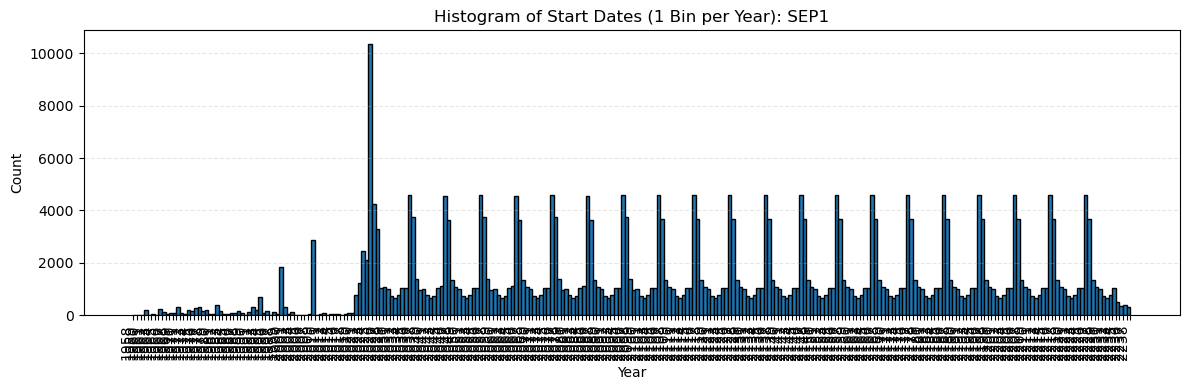

In [19]:
# 1) Build date_start if you haven’t already
T_new['date_start'] = pd.to_datetime({
    'year':  T_new.year_start.astype(int),
    'month': T_new.month_start.astype(int),
    'day':   T_new.day_start.astype(int)
})

# 2) Create yearly bins from min to max year
year_min = T_new['date_start'].dt.year.min()
year_max = T_new['date_start'].dt.year.max()
bins = pd.date_range(start=f"{year_min}-01-01", 
                     end=f"{year_max+1}-01-01", 
                     freq='YS')  # Year Start

# 3) Plot histogram with date bins
fig, ax = plt.subplots(figsize=(12,4))
ax.hist(T_new['date_start'], bins=bins, edgecolor='black')

# 4) bin edges as ticks, label by year
ax.set_xticks(bins)
ax.set_xticklabels([dt.year for dt in bins], rotation=90, ha='right')

# 5) Beautify
ax.set_title('Histogram of Start Dates (1 Bin per Year): SEP1')
ax.set_xlabel('Year')
ax.set_ylabel('Count')
ax.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_74881/1252522104.py:2: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  mass_total = df['mass'].resample('A').sum()
/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_74881/1252522104.py:5: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  mass_main    = df[df['phase']==2]['mass'].resample('A').sum()
/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_74881/1252522104.py:6: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  mass_disposal= df[df['phase']==3]['mass'].resample('A').sum()
/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_74881/1252522104.py:7: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  mass_debris  = df[df['phase']==4]['mass'].resample('A').sum()


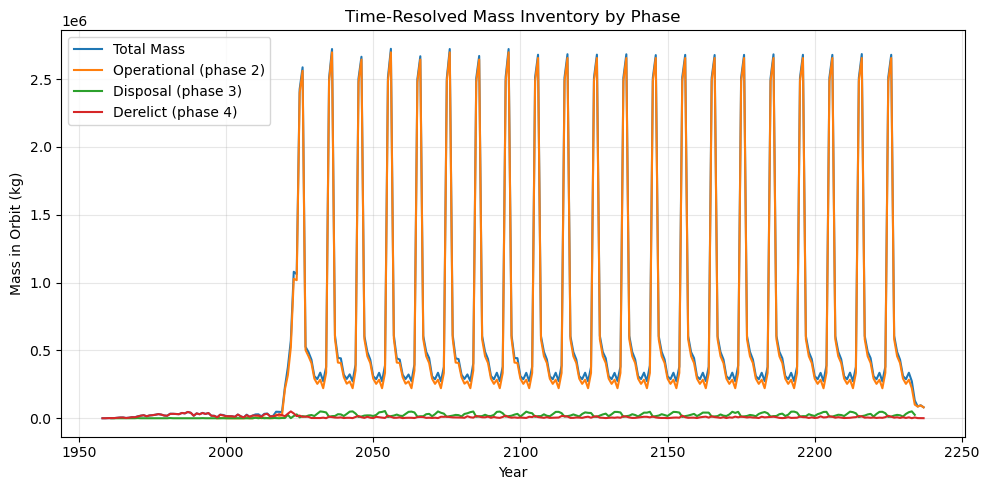

In [20]:
df = T_new.set_index('date_start')
mass_total = df['mass'].resample('A').sum()  

# 4) Mass per phase each year
mass_main    = df[df['phase']==2]['mass'].resample('A').sum()
mass_disposal= df[df['phase']==3]['mass'].resample('A').sum()
mass_debris  = df[df['phase']==4]['mass'].resample('A').sum()

plt.figure(figsize=(10,5))
plt.plot(mass_total.index.year,    mass_total,     label='Total Mass')
plt.plot(mass_main.index.year,     mass_main,      label='Operational (phase 2)')
plt.plot(mass_disposal.index.year, mass_disposal,  label='Disposal (phase 3)')
plt.plot(mass_debris.index.year,   mass_debris,    label='Derelict (phase 4)')

plt.xlabel('Year')
plt.ylabel('Mass in Orbit (kg)')
plt.title('Time-Resolved Mass Inventory by Phase')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


NameError: name 'ticker' is not defined

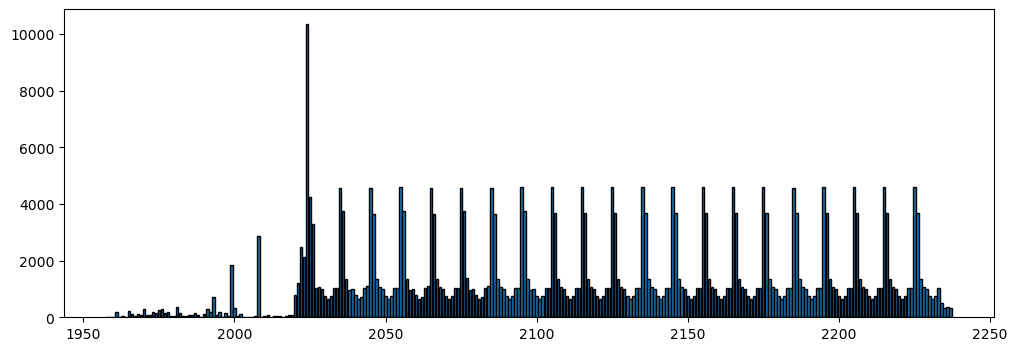

In [21]:
# 1) Ensure you have a datetime column called date_start
T_new['date_start'] = pd.to_datetime({
    'year':  T_new.year_start.astype(int),
    'month': T_new.month_start.astype(int),
    'day':   T_new.day_start.astype(int)
})

# 2) Aggregate into one count per calendar year
annual_counts = T_new['date_start'].dt.year.value_counts().sort_index()

# 3) Plot as a bar chart, one bar per year, ticks every 5 years
fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(annual_counts.index, annual_counts.values, width=0.8, edgecolor='black')

ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.set_xticklabels(annual_counts.index, rotation=45, ha='right')

ax.set_title('Histogram of Start Dates (1 Bin per Year): SEP3H')
ax.set_xlabel('Year')
ax.set_ylabel('Count')
ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
print(T_new['date_start'].min())
print(T_new['date_start'].max())

In [ ]:
# # 1) sim start date
# start_date = "01/01/2025"
# month, day, year = map(int, start_date.split("/"))

# # 2) Convert to Modified Julian Date
# t0 = Time(f"{year}-{month:02d}-{day:02d}", format="iso", scale="utc")
# mjd0 = t0.mjd
# print(f"Simulation t₀ = {start_date} → MJD {mjd0:.6f}")

# # 3) Filter your DataFrame
# #    Keep only objects whose mjd_start is ≤ mjd0 (i.e. in orbit by t₀)
# initial = T_new.loc[T_new['mjd_start'] <= mjd0].copy()

# # 4) Sanity check
# print(f"Total objects in table:        {len(T_new)}")
# print(f"Objects in initial population: {len(initial)}")
# print(f"Objects launched after t₀:     {(T_new['mjd_start'] > mjd0).sum()}")

# # 5) Now plot or analyze `initial` only
# #    e.g. mass histogram for initial population:
# import matplotlib.pyplot as plt
# plt.hist(initial['mass'].dropna(), bins=50, edgecolor='black')
# plt.title(f"Mass Distribution of Initial Population\n(before or on {start_date})")
# plt.xlabel("Mass (kg)")
# plt.ylabel("Count")
# plt.grid(alpha=0.4)
# plt.tight_layout()
# plt.show()


## Preliminary Plotting, All Species

In [ ]:
max_mass = 10000
heavy = T_new[T_new['mass'] > max_mass]

print(f"Number of objects > {max_mass} kg: {len(heavy)}")
print(heavy['species_class'].value_counts())

# max_mass_i = 10000
# heavy_i = initial[initial['mass'] > max_mass_i]

# print(f"Number of objects > {max_mass_i} kg: {len(heavy_i)}")
# print(heavy_i['species_class'].value_counts())


In [ ]:
all_species = T_new['species_class'].dropna().unique()
bins = np.arange(0, max_mass + 500, 100)
plt.figure(figsize=(6,4))

for species in all_species:
    mask = (T_new['mass'] < max_mass) & (T_new['species_class'] == species)
    subset = T_new.loc[mask, 'mass'].dropna()
    # overlay each species, with a bit of transparency
    plt.hist(subset, bins=bins, alpha=0.5, label=species, edgecolor='black')

plt.title(f"Mass Distribution (<{max_mass} kg) by Species")
plt.xlabel("Mass (kg)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Species")

plt.grid(axis='y', linestyle='--', alpha=0.8)
plt.tight_layout()
plt.show()


n = len(all_species)
ncols = 2
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(6, 3*nrows), sharex=False, sharey=False)
axes = axes.flatten()

for ax, sp in zip(axes, all_species):
    data = T_new.loc[
        (T_new['species_class']==sp) & 
        (T_new['mass'] < max_mass),
        'mass'
    ].dropna()

    ax.hist(data, bins=bins, edgecolor='black')
    ax.set_title(f"Species = {sp}")
    ax.set_xlim(0, max_mass)
    ax.set_xlabel("Mass (kg)")
    ax.set_ylabel("Count")
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.4)

fig.suptitle(f"Mass Distributions (<{max_mass} kg) by Species", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
all_species = T_new['species_class'].dropna().unique()
bins = 60
plt.figure(figsize=(6,4))

for species in all_species:
    mask = (T_new['species_class'] == species)
    subset = T_new.loc[mask, 'radius'].dropna()
    plt.hist(subset, bins=bins, alpha=0.5, label=species, edgecolor='black')

plt.title(f"Radius Distribution by Species")
plt.xlabel("Radius (m)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title="Species")

plt.grid(axis='y', linestyle='--', alpha=0.8)
plt.tight_layout()
plt.show()


n = len(all_species)
ncols = 2
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(6, 3*nrows), sharex=False, sharey=False)
axes = axes.flatten()

for ax, sp in zip(axes, all_species):
    data = T_new.loc[
        (T_new['species_class']==sp),
        # (T_new['mass'] < max_mass),
        'radius'
    ].dropna()

    ax.hist(data, bins=bins, edgecolor='black')
    ax.set_title(f"Species = {sp}")
    # ax.set_xlim(0, max_mass)
    ax.set_xlabel("Radius (m)")
    ax.set_ylabel("Count")
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.4)

fig.suptitle(f"Radius Distributions by Species", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
# pick only the rows with both mass & radius
mass_radius_df = T_new[['species_class','mass','radius']].dropna()

for sp, group in mass_radius_df.groupby('species_class'):
    plt.figure(figsize=(6,4))
    plt.scatter(
        group['radius'],
        group['mass'],
        s=20,
        alpha=0.6,
        edgecolor='k'
    )
    plt.title(f"Mass vs. Radius — Species {sp}")
    plt.xlabel("Radius (m)")
    plt.ylabel("Mass (kg)")
    plt.grid(True, linestyle='--', alpha=0.4)
    # optional log scale if needed:
    # plt.xscale('log'); plt.yscale('log')
    plt.tight_layout()
    plt.show()
    
    # TODO:
    # check how many points to verify:
# Species class distribution:
# species_class
# N          54704
# S           6906
# Sns         3356
# Unknown     2536
# B           2082


## Statistical Analysis

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn_extra.cluster import KMedoids

In [ ]:
# mass_radius_df = T_new[['species_class','mass','radius']].dropna()
species_groups = mass_radius_df.groupby('species_class')

In [ ]:
# 1) Prepare your data: pick only the species you want (e.g. S, station-keeping sats)
df = T_new[T_new['species_class']=='S'][['radius','mass']].dropna()
X = df.values
Xs = StandardScaler().fit_transform(X)

inertia_kmeans  = []
resid_kmedians  = []

# 2) Compute WCSS (inertia) for k = 1…8
ks = range(1,9)
for k in ks:
    km = KMeans(n_clusters=k, random_state=0).fit(Xs)
    inertia_kmeans.append(km.inertia_)  
    
    # k-medians
    kmn = KMedoids(n_clusters=k, metric='manhattan', init='k-medoids++', random_state=0)
    kmn.fit(Xs)
    # sum of L1 distances to each cluster’s medoid
    resid = np.sum(kmn.inertia_)  # sklearn_extra uses ‘inertia_’ as sum of distances
    resid_kmedians.append(resid)

# 3) Plot the elbow
plt.figure(figsize=(6,3))
plt.plot(ks, inertia_kmeans, '-o', label='K-Means Inertia')
plt.xticks(ks)
plt.xlabel('Number of clusters k')
plt.ylabel('Within-cluster sum of squares')
plt.title('Residual vs. Clusters (Species S)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# TODO: check more into the elbow method and include for all species

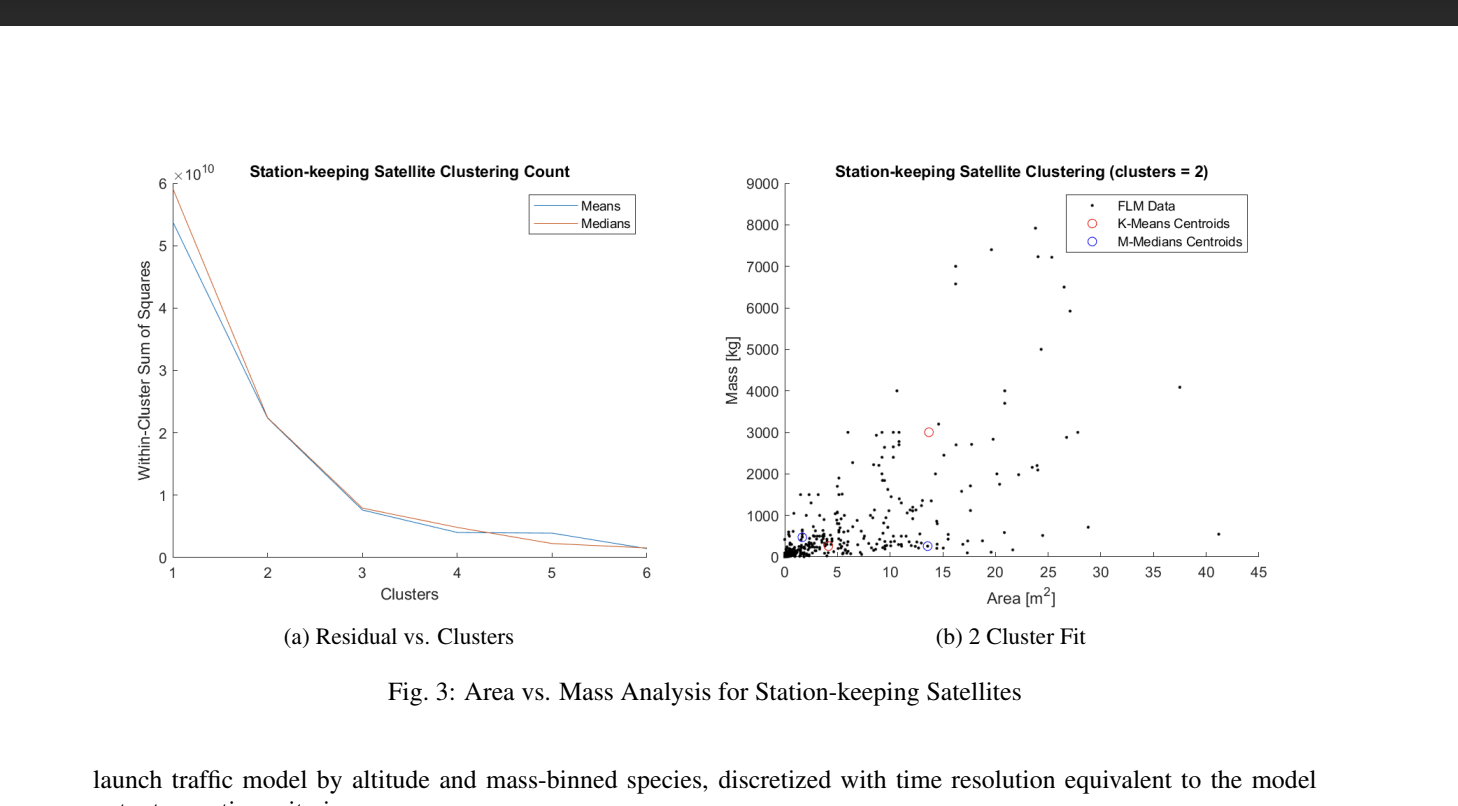

In [ ]:

k = 3
km = KMeans(n_clusters=k, random_state=0).fit(X)
labels = km.labels_
centers = km.cluster_centers_

# 5) Scatter Area vs Mass with centroids
plt.figure(figsize=(6,4))
plt.scatter(df['radius'], df['mass'], c=labels, cmap='tab10', s=20, alpha=0.6, label='Data')
plt.scatter(centers[:,0], centers[:,1], 
            marker='X', s=200, c='black', label='Centroids')
plt.xlabel('Radius (m)')
plt.ylabel('Mass (kg)')
plt.title(f'Radius vs. Mass Clustering (k={k})')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()